# Imports

In [1]:
import datetime
import glob
import itertools
import json
import os
import pickle
import random
import re
from string import punctuation

import dill

In [2]:
import statistics

import fuzzywuzzy
import geopandas as gpd
import humanize
import janitor
import janitor.ml
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib.ticker import PercentFormatter

px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from mlxtend.plotting import plot_decision_regions
from sklearn import __version__ as sklearn_version
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              GradientBoostingClassifier,
                              GradientBoostingRegressor,
                              RandomForestClassifier, RandomForestRegressor,
                              VotingClassifier)
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, average_precision_score,
                             classification_report, confusion_matrix, log_loss,
                             mean_absolute_error, mean_squared_error,
                             plot_precision_recall_curve,
                             precision_recall_curve, r2_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score,
                                     cross_validate, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (LabelEncoder, MaxAbsScaler, MinMaxScaler,
                                   Normalizer, StandardScaler, normalize,
                                   scale)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# FIFA

## Data

In [22]:
fifa = pd.read_csv("datasets/fifa_18_sample_data.csv").clean_names()
fifa.drop_duplicates(inplace=True)
fifa.drop("id", axis=1, inplace=True)
fifa = fifa.select_dtypes(include=["number"])
print(fifa.shape)
fifa.sample(5)

(1000, 79)


,special,age,height_cm,weight_kg,eur_value,eur_wage,eur_release_clause,overall,potential,pac,...,cb,lb,lwb,ls,lf,lam,lcm,ldm,lcb,gk
394,1979,22,173.0,69.0,21000000.0,60000.0,47300000.0,80,87,82,...,55.0,62.0,64.0,79.0,80.0,78.0,71.0,59.0,55.0,NaN
809,1648,26,186.0,81.0,11500000.0,24000.0,NaN,78,83,47,...,77.0,68.0,65.0,60.0,55.0,52.0,57.0,69.0,77.0,NaN
379,2001,31,187.0,89.0,16000000.0,84000.0,25600000.0,81,81,72,...,55.0,56.0,59.0,79.0,77.0,75.0,71.0,59.0,55.0,NaN
606,1276,26,189.0,88.0,11000000.0,17000.0,16200000.0,79,82,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0
93,1750,36,187.0,87.0,5000000.0,105000.0,8300000.0,85,85,71,...,83.0,75.0,71.0,53.0,55.0,58.0,63.0,76.0,83.0,NaN


In [25]:
# fillna and preserve types
orig_dtypes = fifa.dtypes.to_dict()
fifa.fillna(0, inplace=True)
fifa = fifa.apply(lambda x: x.astype(orig_dtypes[x.name]))

In [50]:
# inspect
profile_report = fifa.profile_report(
    sort=None,
    explorative=False,
    minimal=True,
    html={"style": {"full_width": True}},
    progress_bar=True,
)
profile_report.to_file("docs/profile.html")

Summarize dataset:   0%|          | 0/94 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
for c in sorted(fifa.columns):
    print(c)

acceleration
age
aggression
agility
balance
ball_control
cam
cb
cdm
cf
cm
composure
crossing
curve
def
dri
dribbling
eur_release_clause
eur_value
eur_wage
finishing
free_kick_accuracy
gk
gk_diving
gk_handling
gk_kicking
gk_positioning
gk_reflexes
heading_accuracy
height_cm
interceptions
international_reputation
jumping
lam
lb
lcb
lcm
ldm
lf
lm
long_passing
long_shots
ls
lw
lwb
marking
overall
pac
pas
penalties
phy
positioning
potential
ram
rb
rcb
rcm
rdm
reactions
rf
rm
rs
rw
rwb
sho
short_passing
shot_power
skill_moves
sliding_tackle
special
sprint_speed
st
stamina
standing_tackle
strength
vision
volleys
weak_foot
weight_kg


## Whitening

In [32]:
# whiten columns
fifa_whitened = pd.DataFrame(sp.cluster.vq.whiten(fifa), columns=fifa.columns)

          eur_wage    eur_value
count  1000.000000  1000.000000
mean      1.119812     1.306272
std       1.000500     1.000500
min       0.000000     0.000000
25%       0.467717     0.730412
50%       0.854794     1.022576
75%       1.407184     1.542995
max       9.112425     8.984064


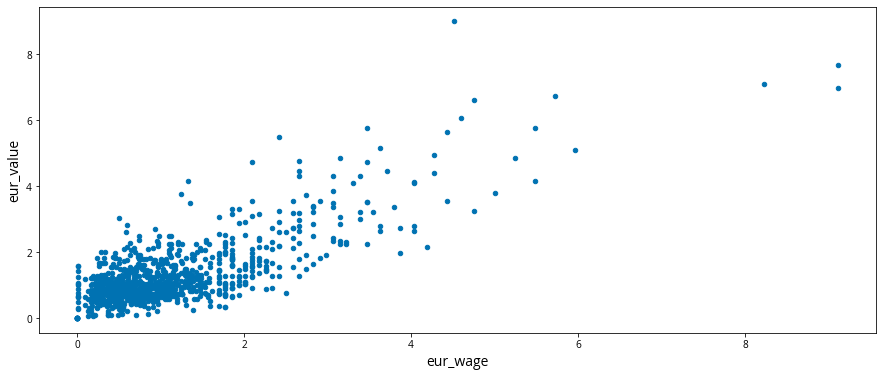

In [38]:
# Plot the two columns in a scatter plot
fifa_whitened.plot(x="eur_wage", y="eur_value", kind="scatter")

# Check mean and standard deviation of scaled values
print(fifa_whitened[["eur_wage", "eur_value"]].describe())

<div class="alert alert-block alert-warning">
<b>Whitening != Scaling</b></div>

            ss_wage      ss_value
count  1.000000e+03  1.000000e+03
mean   2.697842e-16  8.451573e-16
std    1.000500e+00  1.000500e+00
min   -1.119812e+00 -1.306272e+00
25%   -6.520948e-01 -5.758602e-01
50%   -2.650184e-01 -2.836955e-01
75%    2.873720e-01  2.367228e-01
max    7.992613e+00  7.677792e+00


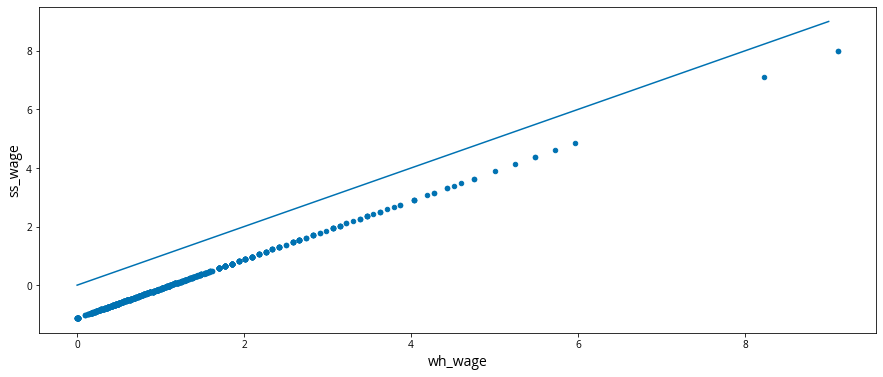

In [39]:
# standardscaler != whitening

# Scale wage and value
fifa["wh_wage"] = sp.cluster.vq.whiten(fifa["eur_wage"])
fifa["wh_value"] = sp.cluster.vq.whiten(fifa["eur_value"])

fifa["ss_wage"] = StandardScaler().fit_transform(fifa["eur_wage"].values.reshape(-1, 1))
fifa["ss_value"] = StandardScaler().fit_transform(
    fifa["eur_value"].values.reshape(-1, 1)
)
print(fifa[["ss_wage", "ss_value"]].describe())
fifa.plot(x="wh_wage", y="ss_wage", kind="scatter")
x = [_ for _ in range(0, 10)]
plt.plot(x, x)

           mm_wage     mm_value
count  1000.000000  1000.000000
mean      0.122888     0.145399
std       0.109795     0.111364
min       0.000000     0.000000
25%       0.051327     0.081301
50%       0.093805     0.113821
75%       0.154425     0.171748
max       1.000000     1.000000


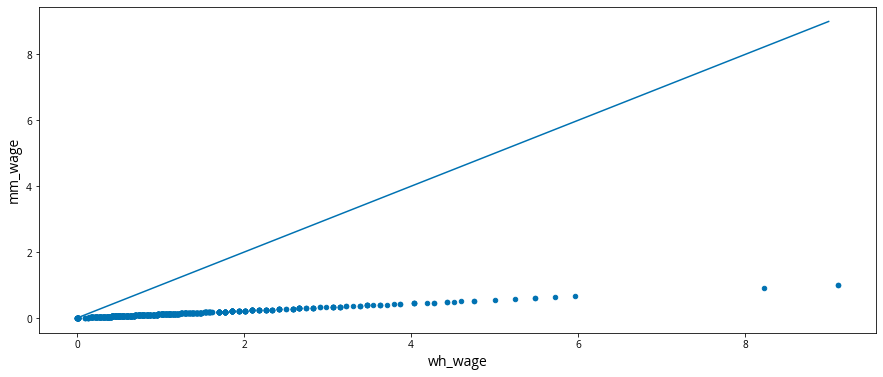

In [40]:
# minmaxscaler != whitening
fifa["mm_wage"] = MinMaxScaler().fit_transform(fifa["eur_wage"].values.reshape(-1, 1))
fifa["mm_value"] = MinMaxScaler().fit_transform(fifa["eur_value"].values.reshape(-1, 1))
print(fifa[["mm_wage", "mm_value"]].describe())
fifa.plot(x="wh_wage", y="mm_wage", kind="scatter")
x = [_ for _ in range(0, 10)]
plt.plot(x, x)

<div class="alert alert-block alert-warning">
<b></b></div>

## Hierarchical Clustering

                sliding_tackle  aggression
cluster_labels                            
1                    74.698355   76.930530
2                    15.266187   31.748201
3                    30.716561   61.372611


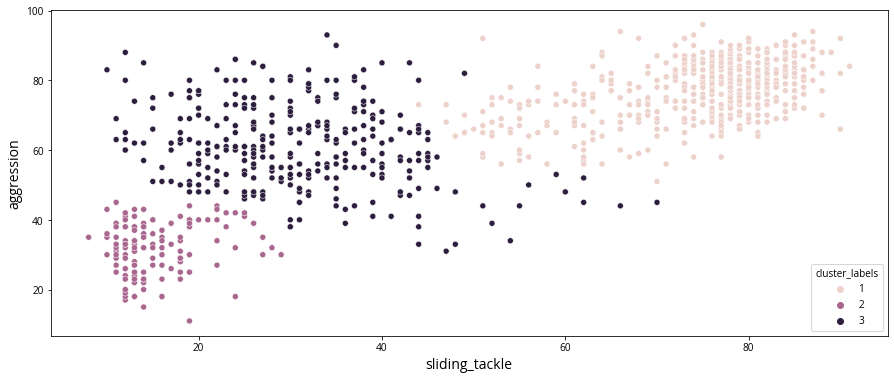

In [44]:
# Fit the data into a hierarchical clustering algorithm
distance_matrix = sp.cluster.hierarchy.linkage(
    fifa_whitened[["sliding_tackle", "aggression"]], "ward"
)

# Assign cluster labels to each row of data
fifa["cluster_labels"] = sp.cluster.hierarchy.fcluster(
    distance_matrix, 3, criterion="maxclust"
)

# Display cluster centers of each cluster
print(
    fifa[["sliding_tackle", "aggression", "cluster_labels"]]
    .groupby("cluster_labels")
    .mean()
)

# Create a scatter plot through seaborn
sns.scatterplot(x="sliding_tackle", y="aggression", hue="cluster_labels", data=fifa)
plt.show()

# ComicCon

## Data

In [46]:
comic_con = pd.read_csv("datasets/comicon.csv", index_col=0)
comic_con.sample(5)

,x_coordinate,y_coordinate,x_scaled,y_scaled
7,30,6,0.898851,0.135015
8,35,5,1.048660,0.112512
23,93,99,2.786439,2.227744
20,94,99,2.816401,2.227744
12,13,8,0.389502,0.180020


## Hierarchical Clustering

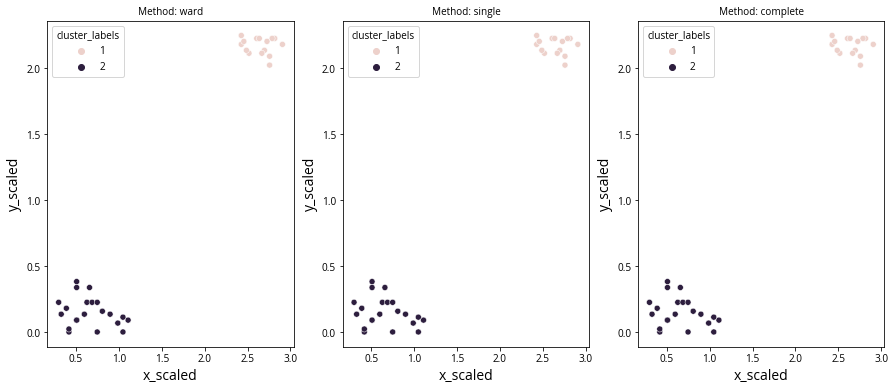

In [47]:
# Import the fcluster and linkage functions
from scipy.cluster.hierarchy import fcluster, linkage

# plots
fig, ax = plt.subplots(1, 3)

for i, method in enumerate(["ward", "single", "complete"]):

    # Use the linkage() function
    distance_matrix = linkage(
        comic_con[["x_scaled", "y_scaled"]], method=method, metric="euclidean"
    )

    # Assign cluster labels
    comic_con["cluster_labels"] = fcluster(distance_matrix, 2, criterion="maxclust")

    # Plot clusters

    sns.scatterplot(
        x="x_scaled", y="y_scaled", hue="cluster_labels", data=comic_con, ax=ax[i]
    )
    ax[i].title.set_text(f"Method: {method}")

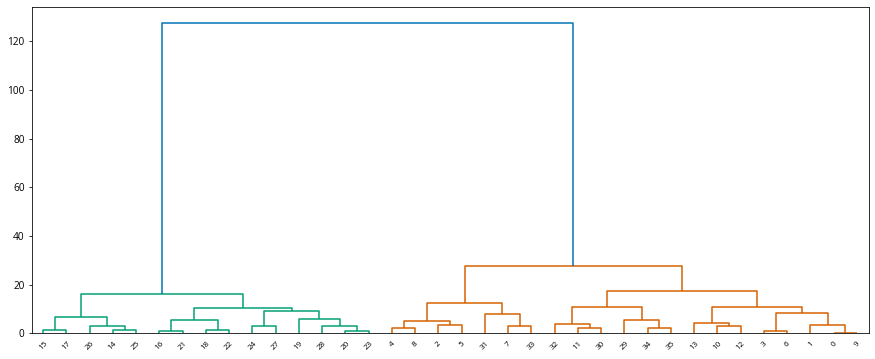

In [48]:
# Calculate the linkage: mergings
Z = sp.cluster.hierarchy.linkage(comic_con, method="complete")

# Plot the dendrogram
_ = sp.cluster.hierarchy.dendrogram(Z)

## Kmeans

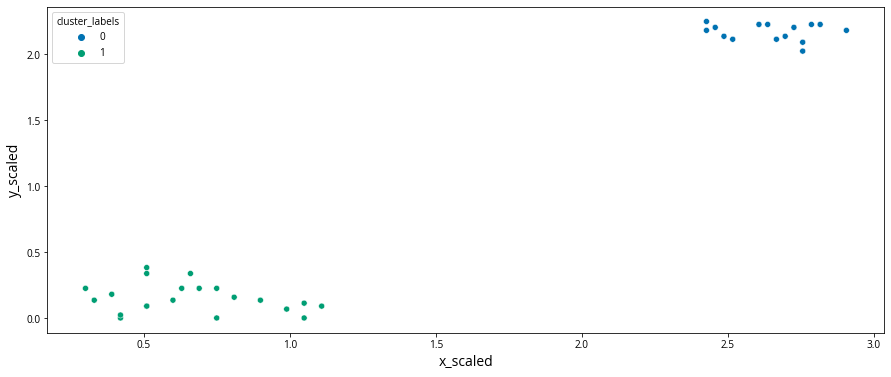

In [49]:
# Import the kmeans and vq functions
from scipy.cluster.vq import kmeans, vq

# Generate cluster centers
cluster_centers, distortion = kmeans(comic_con[["x_scaled", "y_scaled"]], 2)

# Assign cluster labels
comic_con["cluster_labels"], distortion_list = vq(
    comic_con[["x_scaled", "y_scaled"]], cluster_centers
)

# Plot clusters
sns.scatterplot(x="x_scaled", y="y_scaled", hue="cluster_labels", data=comic_con)
plt.show()